### **Using neural networks to LogAnomaly Detection**

In [1]:
from functions import *
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf 

frequencies, weighed_topics=relative_frequency(12)

Loaded file: Corpus\Pionier_medium_11052023_v1.pkl

List with topics-per-log loaded from TopicsPerLog/TPL_12_24112023_(0).pkl


About the data: 

In [2]:
data_og=weighed_topics
print("Num of vectors: ", len(data_og))
print("Vector type: ", type(data_og[0]))

sub_arrays= [np.array(sublist) for sublist in data_og]
data_og = np.array(sub_arrays, dtype=object)

Num of vectors:  2846
Vector type:  <class 'list'>


#### Data

In [3]:
ds= TplPionier(config=config.ds_medium)
errors_idx=list(ds.index[ds.index['ERROR'] == True].index)
data_wo_errors= [data_og[i] for i in range(len(data_og)) if i not in errors_idx]

print(data_wo_errors)

[array([0.03446719, 0.18558098, 0.03446719, 0.03446719, 0.03446719,
       0.18558098, 0.18558098, 0.00978326, 0.18558098, 0.18558098,
       0.18558098, 0.00978326, 0.18558098, 0.03446719, 0.03446719,
       0.18558098, 0.18558098, 0.18558098, 0.18558098, 0.18558098,
       0.18558098, 0.03446719, 0.03446719, 0.18558098, 0.18558098,
       0.03446719, 0.03446719, 0.18558098, 0.18558098, 0.03446719,
       0.18558098, 0.18558098, 0.18558098, 0.03446719, 0.03446719,
       0.03446719, 0.03446719, 0.03446719, 0.18558098, 0.18558098,
       0.18558098, 0.18558098, 0.03446719, 0.18558098, 0.18558098,
       0.03446719, 0.18558098, 0.18558098, 0.18558098, 0.03446719]), array([0.18558098, 0.03446719, 0.03446719, 0.03446719, 0.03446719,
       0.18558098, 0.18558098, 0.00872968, 0.18558098, 0.18558098,
       0.03446719, 0.18558098, 0.18558098, 0.18558098, 0.18558098,
       0.18558098, 0.18558098, 0.03446719, 0.18558098, 0.18558098,
       0.18558098, 0.03446719, 0.03446719, 0.18558098, 0.03

In [4]:
data_cut = [subarray[:100] for subarray in data_wo_errors]

In [5]:
etiqueta=np.zeros(len(data_og))
etiqueta[errors_idx] = 1
print(len(etiqueta))
etiqueta

2846


array([1., 1., 0., ..., 0., 0., 0.])

In [6]:
import tensorflow as tf

data_padded = tf.keras.preprocessing.sequence.pad_sequences(data_cut, padding='post', dtype='float32')

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test= train_test_split(data_padded, test_size=0.2, random_state=42)

In [22]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import SGD
from keras.optimizers import Adam

dim_entrada = 100         
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(64, activation='tanh')(capa_entrada) 
encoder = Dense(32, activation='relu')(encoder) 
encoder = Dropout(0.2)(encoder)  
encoder = Dense(16, activation='tanh')(encoder) 

# Decoder
decoder = Dense(32, activation='relu')(encoder)  
decoder = Dropout(0.2)(decoder)  
decoder = Dense(64, activation='tanh')(decoder)  
decoder = Dense(100, activation='sigmoid')(decoder)  

autoencoder = Model(inputs=capa_entrada, outputs=decoder)


#sgd = SGD(lr=0.01)
adam = Adam(lr=0.01)
autoencoder.compile(optimizer=adam, loss='mse')

nits = 150
tam_lote = 16
history=autoencoder.fit(data_train, data_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(data_test,data_test), verbose=1)

Epoch 1/150
139/139 [==============================] - 1s 2ms/step - loss: 0.0643 - val_loss: 0.0307
Epoch 2/150
139/139 [==============================] - 0s 1ms/step - loss: 0.0140 - val_loss: 0.0081
Epoch 3/150
139/139 [==============================] - 0s 1ms/step - loss: 0.0084 - val_loss: 0.0066
Epoch 4/150
139/139 [==============================] - 0s 1ms/step - loss: 0.0071 - val_loss: 0.0060
Epoch 5/150
139/139 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 6/150
139/139 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 7/150
139/139 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 8/150
139/139 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 9/150
139/139 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 10/150
139/139 [==============================] - 0s 1ms/step - loss: 0.0056 - val_lo

In [35]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_12 (Dense)            (None, 64)                6464      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 32)                544       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0   

Text(0.5, 1.0, 'Loss Curves')

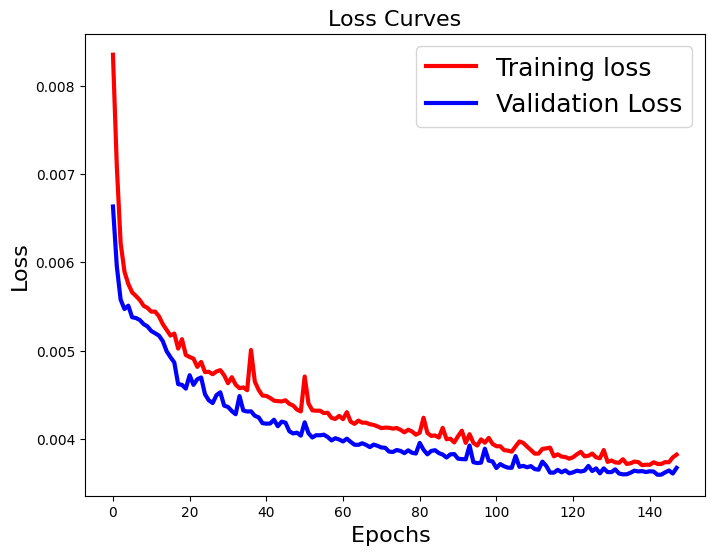

In [38]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'][-148:],'r',linewidth=3.0)
plt.plot(history.history['val_loss'][-148:],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

In [25]:
data_cut_og = [subarray[:100] for subarray in data_og]
data_padded_og = tf.keras.preprocessing.sequence.pad_sequences(data_cut_og, padding='post', dtype='float32')

89/89 [==============================] - 0s 693us/step
(2846, 100)


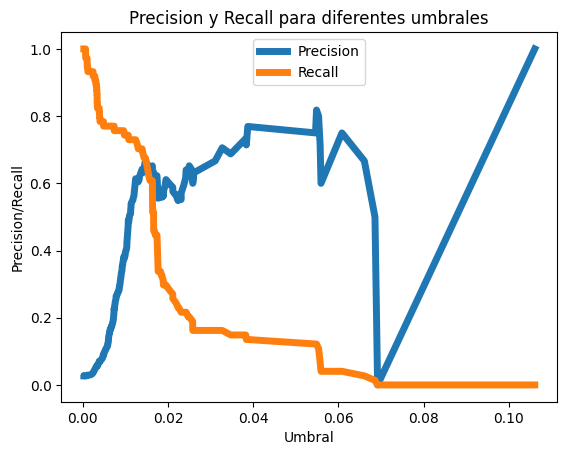

[[2738   34]
 [  20   54]]


In [33]:
X_pred = autoencoder.predict(data_padded_og)
ecm = np.mean(np.power(data_padded_og-X_pred,2), axis=1)
print(X_pred.shape)

# Gráfica precision-recall para determinar el umbral
from sklearn.metrics import confusion_matrix, precision_recall_curve


precision, recall, umbral = precision_recall_curve(etiqueta, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

# 5.3. Matriz de confusión
umbral_fijo = 0.0125
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

conf_matrix = confusion_matrix(etiqueta, Y_pred)
print(conf_matrix)

89/89 [==============================] - 0s 727us/step
Accuracy: 98.10%
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2772
         1.0       0.61      0.73      0.67        74

    accuracy                           0.98      2846
   macro avg       0.80      0.86      0.83      2846
weighted avg       0.98      0.98      0.98      2846

Confusion Matrix:
 [[2738   34]
 [  20   54]]


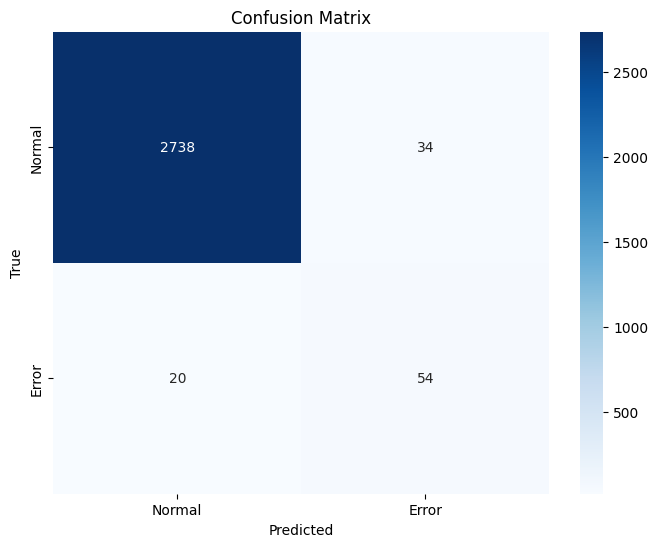

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Hacer predicciones en el conjunto de prueba
X_pred = autoencoder.predict(data_padded_og)

umbral_fijo = 0.0125
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]


# Calcular la matriz de confusión
conf_matrix = confusion_matrix(etiqueta, Y_pred)

# Calcular métricas
accuracy = accuracy_score(etiqueta, Y_pred)
classification_report_str = classification_report(etiqueta, Y_pred)

# Imprimir métricas y matriz de confusión
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report_str)
print("Confusion Matrix:\n", conf_matrix)

# Dibujar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Error'], yticklabels=['Normal', 'Error'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()